# CH4-AIR Notebook 
This notebook contains all the methods and the 2 experiments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns

In [2]:
import tensorflow as tf

In [3]:
import os
os.getcwd()

'/Users/dwyerdeighan/Desktop/Varun_Amol_Proj'

# Load and prepare data

In [4]:
#read the data into a dataframe
#df = pd.read_csv('NewData_flames_data_with_L1_L2_errors_CH4-AIR_with_trimming.txt')
df = pd.read_csv('NewData_flames_data_with_L1_L2_errors_CH4-AIR_without_trimming.txt')
df = df.iloc[:-1]
import math

print(np.sum(list(map(math.isnan, df[' flame_key']))))

#create an integer representation of the flame-id and add to the data frame
df['flame_key_int'] = df[' flame_key'].mul(10000000).astype(int)

#create an integer to determine if the flame is included by the framework in the manifold creation and reverselookup
#framework_untrimmed_flameids = [0.00115982, 0.00122087, 0.00128512, 0.00135276, 0.00142396, 0.0014989, 0.00157779, 0.00166083, 0.00174825, 0.00184026, 0.00193711, 0.00203907, 0.00214639, 0.00225936, 0.00237827, 0.01]

framework_untrimmed_flameids = ['2.0276547153583627E-4', '2.1343733845877503E-4', '2.2467088258818426E-4', '2.3649566588229923E-4', '2.4894280619189394E-4', '2.6204505914936203E-4', '2.7583690436774953E-4', '2.903546361765785E-4', '3.056364591332405E-4', '3.2172258856130585E-4', '3.3865535638032194E-4', '0.0032353354497370902']


framework_untrimmed_flame_key_ints = [int(float(framework_untrimmed_flameids[i])*10000000) for i in range(len(framework_untrimmed_flameids))]

def isFlame_included(flame_key_int):
    if flame_key_int in framework_untrimmed_flame_key_ints:
        ret_val = 1
    else:
        ret_val = 0
    return ret_val

df['is_flame_included_by_framework'] = df['flame_key_int'].map(lambda x: isFlame_included(x))

df['souener_deciles'] = pd.qcut(df['souener'],10)


0


In [6]:
def train_test_split_on_flamekey(df, train_portion=0.5):
    import random
    random.seed(0)
    flame_keys = list(set(df['flame_key_int']))
    random.shuffle(flame_keys)
    train_set_keys = flame_keys[:int(len(flame_keys)*train_portion)]
    test_set_keys = flame_keys[int(len(flame_keys)*train_portion):]
    print('train_set_keys: ', train_set_keys)
    print('test_set_keys: ', test_set_keys)

    train_set = df[np.isin(df['flame_key_int'], train_set_keys)]
    test_set = df[np.isin(df['flame_key_int'], test_set_keys)]
    print('train: ', train_set['flame_key_int'].unique()[:5])
    print('test: ', test_set['flame_key_int'].unique()[:5])
    return train_set, test_set

train_set, test_set = train_test_split_on_flamekey(df)

train_set_keys:  [26352, 4849, 2134, 3752, 14989, 4376, 2903, 5656, 2620, 3949, 6597, 3386, 11018, 12851, 5953, 20390, 3217, 8974, 4606, 27738, 16608, 22593, 3564, 19371, 7309, 14239, 32353]
test_set_keys:  [23782, 7694, 21463, 17482, 12208, 2489, 5104, 25034, 3056, 2758, 2364, 8525, 30735, 29198, 15777, 2246, 4157, 9446, 2027, 8099, 10467, 11598, 9944, 18402, 6267, 5373, 6944, 13527]
train:  [32353 27738 26352 22593 20390]
test:  [30735 29198 25034 23782 21463]


### Create PCAs using all the data and add to DF


In [5]:
num_principal_components = 5

pca = PCA(n_components=num_principal_components)

icovariates = []
for c in df.columns:
    if c[0:2] == 'Yi':
        icovariates.append(c)

X = df[icovariates].values
        
pure_pca_dim_cols = ["PURE_PCA_"+str(i+1) for i in range(num_principal_components)]

pca.fit_transform(X)
        
df_pure_pca = pd.DataFrame(pca.transform(X), columns = pure_pca_dim_cols)
        
df = pd.concat([df,df_pure_pca], axis=1)


In [6]:
#don't run this
'''
pca = PCA().fit(X)
plt.xticks(np.arange(0, 40, 2.0))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
'''

"\npca = PCA().fit(X)\nplt.xticks(np.arange(0, 40, 2.0))\nplt.plot(np.cumsum(pca.explained_variance_ratio_))\nplt.xlabel('number of components')\nplt.ylabel('cumulative explained variance');\n"

### Create Sparse PCA

In [7]:
sparsepca = SparsePCA(n_components=num_principal_components)
      
sparse_pca_dim_cols = ["SPARSE_PCA_"+str(i+1) for i in range(num_principal_components)]

sparsepca.fit_transform(X)
        
df_sparse_pca = pd.DataFrame(sparsepca.transform(X), columns = sparse_pca_dim_cols)
        
df = pd.concat([df,df_sparse_pca], axis=1)

### Create PCAs orthogonal to Zmix and add to DF

In [8]:
zmix_pca_dim_cols = ["Zmix_PCA_"+str(i+1) for i in range(num_principal_components)]

wopt = np.array([0.25131806468584, 1.0, 0.0, 0.0, 0.05926499970012948, 0.11189834407236524, 0.03053739933116691, 0.05926499970012948, 0.0, 0.07742283372149472, 0.14371856860332313, 0.14371856860332313, 0.20112514400193687, 1.0, 0.0, 0.0, 0.03473494419333629, 0.06713785861443991, 0.09743596683886535, 0.09743596683886535, 0.12582790137651187, 0.04027033873046593, 0.07742283372149472, 0.11180607885607882, 0.14371856860332313, 0.17341738612784788, 0.20112514400193687, 0.024566681794273966, 0.04795526192839207, 0.04795526192839207, 0.0, 0.06713048065088474, 0.12581494366075874, 0.17755300484072126, 0.034730994502665966, 0.0, 0.0, 0.0, 0.03249947443158002, 0.0, 0.0372961080230628, 0.07191024382448291, 0.024564706019978535, 0.023426986426879046, 0.023426986426879046, 0.023426986426879046, 0.0, 0.16374935944566987, 0.18286442054789118, 0.07024850027715426, 0.09152158240065958, 0.0, 0.0] , dtype=float)

w = wopt[:,np.newaxis]

# center the data
Xcenter = X - np.mean(X)

A = np.cov(X.T)

# calculate A - ww^TA
L = A - np.dot(np.dot(w,w.T),A)

# get the first eigen vector
values,vectors = np.linalg.eig(L)

vectors = np.real(vectors)

values = np.real(values)

df_zmix_pca = pd.DataFrame(df['flame_key_int'], columns = ['flame_key_int'])

df_zmix_pca[zmix_pca_dim_cols[0]] = Xcenter.dot(wopt)

for i in range(len(zmix_pca_dim_cols)-1):
    df_zmix_pca[zmix_pca_dim_cols[i+1]] = Xcenter.dot(vectors.T[i])

df_zmix_pca = pd.DataFrame(pca.transform(X), columns = zmix_pca_dim_cols)
        
df = pd.concat([df,df_zmix_pca], axis=1)

In [9]:
framework_included_flames_int = df[df['is_flame_included_by_framework'] == 1]['flame_key_int'].unique()

framework_excluded_flames_int = df[df['is_flame_included_by_framework'] == 0]['flame_key_int'].unique()

all_flames_int = df['flame_key_int'].unique()

def getTrainTestFlames(method):
    
    training_flames_int = []

    testing_flames_int = []

    if(method == "frameworkincludedexcludedequalsplit"):
    
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_excluded_flames_int[::2]:
            training_flames_int.append(x)

        for x in framework_included_flames_int:
            testing_flames_int.append(x)

        for x in framework_excluded_flames_int[1::2]:
            testing_flames_int.append(x)
    
    elif(method == "frameworkincludedtrainexcludedtest"):
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_excluded_flames_int:
            testing_flames_int.append(x)
    
    elif(method == "frameworkincludedtrainexcludedandincludedtest"):
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_included_flames_int:
            testing_flames_int.append(x)

        for x in framework_excluded_flames_int:
            testing_flames_int.append(x)
            
    else:
        for x in all_flames_int:
            training_flames_int.append(x)
            testing_flames_int.append(x)
    
    df_training = df[df['flame_key_int'].isin(training_flames_int)]

    df_testing = df[df['flame_key_int'].isin(testing_flames_int)]
    
    return df_training,df_testing


def getTrainTestData(method):
    
    method_parts = method.split('_')

    df_trainingFlames, df_testingFlames = getTrainTestFlames(method_parts[1])

    if method_parts[0] == "ZmixCpv":
        X_train = df_trainingFlames [["Zmix","Cpv"]].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [["Zmix","Cpv"]].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    elif method_parts[0] == "ZmixPCA":
        X_train = df_trainingFlames [zmix_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [zmix_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
        
    elif method_parts[0] == "SparsePCA":
        X_train = df_trainingFlames [sparse_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [sparse_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    elif method_parts[0] == "PurePCA":
        X_train = df_trainingFlames [pure_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [pure_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
        
    else:
        X_train = df_trainingFlames [icovariates].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [icovariates].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    return X_train,Y_train,X_test,Y_test

In [10]:
def computeError (Y_pred, Y_test):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

    evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']
    
    evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 
    
    TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

    TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()
    
    MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

    MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()
    
    NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()
    
    MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints
    
    return [TotalAbsoluteError,TotalSquaredError,MeanAbsoluteError,MeanSquaredError,MeanPercentageError,NumPoints]

def printError (err):
    TotalAbsoluteError = err[0]

    TotalSquaredError = err[1]

    MeanAbsoluteError = err[2]

    MeanSquaredError = err[3]

    MeanPercentageError = err[4]

    NumPoints = err[5]
    print ('Total Absolute Error: ', TotalAbsoluteError)
    print ('Mean Absolute Error: ', MeanAbsoluteError)
    print ('Mean Percentage Error: ', MeanPercentageError)
    print ('Total Squared Error: ', TotalSquaredError)
    print ('Mean Squared Error: ', MeanSquaredError)
    print ('Number of Points: ', NumPoints)

def computeAndPrintError(Y_pred, Y_test):    
    err = computeError (Y_pred, Y_test)
    printError (err)
    return err



In [11]:
class CustomGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=150, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min




def fitGPAndCalcL1Err(X_train, Y_train, X_test, Y_test,kernel="Matern"):
    
    if kernel == "Matern_RationalQuadratic":
        
        # medium term irregularities
        k1 = 0.5* Matern(length_scale=2, nu=3/2)
        k2 = 0.5* RationalQuadratic(length_scale=1.0, alpha=1.0)
    
        '''
        k4 = 0.1**2 * RBF(length_scale=0.1) \+ WhiteKernel(noise_level=0.1**2,
                      noise_level_bounds=(1e-3, np.inf))  # noise terms
        '''
        kernel = k1 + k2
    
    elif kernel == "RationalQuadratic":
        
        # medium term irregularities
        kernel = RationalQuadratic(length_scale=1.0, alpha=1.0)    
    
    else:
        kernel = Matern(length_scale=2, nu=3/2)
    
    #gp_1 = gaussian_process.GaussianProcessRegressor(kernel=kernel)

    
    t = time.process_time()

    gp_1 = CustomGPR(kernel=kernel)
    
    gp_1.fit(X_train, Y_train)

    elapsed_time = time.process_time() - t

    print ("GP Time for Initial Fit: ", elapsed_time)
    
    t = time.process_time()
    
    #Y_pred = gp_1.predict(X_test, return_std=False)
    Y_pred = gp_1.predict(X_test, return_std=False)
    
    elapsed_time = time.process_time() - t

    print ("GP Time for Prediction: ", elapsed_time)
    
    err = computeAndPrintError(Y_pred, Y_test)
    
    return gp_1, err,Y_pred

In [12]:
df[["Zmix","Zmix_PCA_1","Zmix_PCA_2","Zmix_PCA_3","Zmix_PCA_4","Zmix_PCA_5","souener"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Zmix,16441.0,4.300753e-01,2.603548e-01,4.542561e-03,2.126891e-01,3.964378e-01,6.316525e-01,9.954029e-01
Zmix_PCA_1,16441.0,-1.555838e-17,3.251895e-01,-4.906146e-01,-2.377393e-01,-1.149401e-01,2.354814e-01,7.919904e-01
Zmix_PCA_2,16441.0,-2.052842e-18,2.386475e-01,-3.176912e-01,-1.897163e-01,-4.602780e-02,1.333178e-01,7.845406e-01
Zmix_PCA_3,16441.0,1.195240e-17,6.041821e-02,-1.516269e-01,-2.526227e-02,3.244706e-03,3.534856e-02,1.816277e-01
Zmix_PCA_4,16441.0,-2.649787e-17,1.796422e-02,-4.138414e-02,-1.144189e-02,-1.985625e-03,7.267487e-03,5.825280e-02
Zmix_PCA_5,16441.0,2.336459e-18,1.219545e-02,-2.677533e-02,-8.928321e-03,-4.568207e-04,8.279846e-03,2.862893e-02
souener,16441.0,1.235628e+10,2.958959e+10,-2.857737e+09,4.573454e+07,1.461805e+09,8.146965e+09,2.041413e+11


In [13]:
df["souener"].describe()

count    1.644100e+04
mean     1.235628e+10
std      2.958959e+10
min     -2.857737e+09
25%      4.573454e+07
50%      1.461805e+09
75%      8.146965e+09
max      2.041413e+11
Name: souener, dtype: float64

## DNN Method Support Functions

In [14]:
from numpy import genfromtxt
def get_neighborhood(neighborhooddisttype,datasettype):
    #neighbors_cosine_dataset_test_ZmixPCA_frameworkincludedexcludedequalsplit
    train_filename = "neighbors_" + neighborhooddisttype + "_dataset_train_" + datasettype + ".csv"
    test_filename = "neighbors_" + neighborhooddisttype + "_dataset_test_" + datasettype + ".csv"
    neighbors_dataset_train = genfromtxt(train_filename, delimiter=',')
    neighbors_dataset_test = genfromtxt(test_filename, delimiter=',')
    return neighbors_dataset_train,neighbors_dataset_test

def computeAndSaveNeighborhood():        
    # Train distance function
    neighbors_dataset_train = list()

    for i in range(X_train.shape[0]):
        neighbors_dataset_train.append(get_neighbors(X_train, Y_train, X_train[i], num_neighbors,"manhattan"))

    # Test distance function
    neighbors_dataset_test = list()

    for i in range(X_test.shape[0]):
        neighbors_dataset_test.append(get_neighbors(X_train, Y_train, X_test[i], num_neighbors,"manhattan"))

    neighbors_dataset_train = np.asarray(neighbors_dataset_train)
    neighbors_dataset_test = np.asarray(neighbors_dataset_test)
    from numpy import savetxt
    savetxt('neighbors_dataset_train_ZmixPCA.csv', neighbors_dataset_train, delimiter=',')
    savetxt('neighbors_dataset_test_ZmixPCA.csv', neighbors_dataset_test, delimiter=',')

In [15]:
# Example of getting neighbors for an instance
from math import sqrt
from scipy import spatial

num_neighbors = 48

# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# calculate the Euclidean distance between two vectors
def weighted_euclidean_distance(row1, row2):
    distance = 0.0
    j = len(row1)
    for i in range(len(row1)-1):
        distance += j*(row1[i] - row2[i])**2
        j = j -1
    return sqrt(distance)

# calculate the Manhattan distance between two vectors
def weighted_manhattan_distance(row1, row2):
    distance = 0.0
    j = len(row1)
    for i in range(len(row1)-1):
        distance += j* abs(row1[i] - row2[i])
        j = j -1
    return distance

# calculate the Manhattan distance between two vectors
def manhattan_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += abs(row1[i] - row2[i])
    return distance

def cosine_distance(row1, row2):
    distance = 0.0
    distance = 1 - spatial.distance.cosine(row1, row2)
    return distance


# Locate the most similar neighbors
def get_neighbors(train, train_label, test_row, num_neighbors,dist_type):
    
    distances = list()
    
    i = 0
    
    for train_row in train:
        
        if dist_type == "cosine":
            dist = cosine_distance(test_row, train_row)
        elif dist_type == "manhattan":
            dist = manhattan_distance(test_row, train_row)    
        elif dist_type == "weighted_manhattan":
            dist = weighted_manhattan_distance(test_row, train_row)    
        elif dist_type == "weighted_euclidean":
            #euclidean":
            dist = weighted_euclidean_distance(test_row, train_row)
        else:
            #euclidean":
            dist = euclidean_distance(test_row, train_row)
        
        distances.append((train_label[i],train_row, dist))
        
        i = i + 1
    
    distances.sort(key=lambda tup: tup[2])
   
    neighbors = list()
    
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    
    neighbors = np.asarray(neighbors).flatten()
    
    return neighbors

In [16]:
def getResiduals(Y_test,Y_pred):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['res'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 
   
    return evaluation_df_1['res'].values


In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Souener]')
    plt.legend()
    plt.grid(True)

# Experiment I
## Training on all Untrimed Flames
### Zmix, Cpv

In [18]:
#ZmixPCA_frameworkincludedtrainexcludedtest
#ZmixPCA_frameworkincludedexcludedequalsplit
X_train,Y_train,X_test, Y_test  = getTrainTestData("ZmixCpv_frameworkincludedtrainexcludedtest")


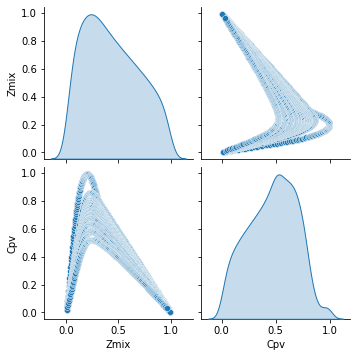

In [19]:
#X_train_df = pd.DataFrame(X_train ,columns = zmix_pca_dim_cols)
X_train_df = pd.DataFrame(X_train ,columns = ["Zmix","Cpv"])
sns.pairplot(X_train_df, diag_kind='kde')

#The following image is not used in the Paper; may be we can add it to give a better description

### GP Matern Kernel

In [20]:
print ('Zmix+PCA(2 components) trained using Framework Included Flames and Test on Flames Excluded by Framework\n')
gp,err, Y_pred = fitGPAndCalcL1Err(X_train, Y_train.flatten(), X_test, Y_test.flatten())

Zmix+PCA(2 components) trained using Framework Included Flames and Test on Flames Excluded by Framework



/Users/dwyerdeighan/opt/miniconda3/envs/rom/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GP Time for Initial Fit:  44.307576
GP Time for Prediction:  1.9146460000000047
Total Absolute Error:  77046923711119.56
Mean Absolute Error:  5992605095.365914
Mean Percentage Error:  0.9781810518642399
Total Squared Error:  2.8175944104747773e+24
Mean Squared Error:  2.191486669110039e+20
Number of Points:  12857


In [21]:
errorLst = {}

In [22]:
errorLst['Zmix+PCA(2 Components) GP'] = err

/Users/dwyerdeighan/opt/miniconda3/envs/rom/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

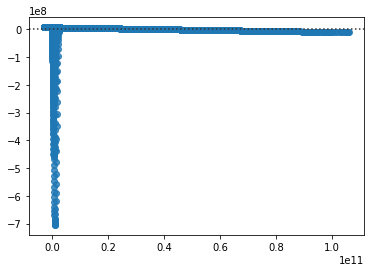

In [23]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Simple DNN 

In [24]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45)

width = 512
halfwidth = 128
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(width, activation='relu'),
      layers.Dense(width, activation='relu'),
      layers.Dense(halfwidth, activation='relu'),
      layers.Dense(halfwidth, activation='relu'),  
      layers.Dense(width, activation='relu'),
      layers.Dense(width, activation='relu'),
      layers.Dense(1)
    ])
        
    
    model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    #model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [25]:
X_normalizer = preprocessing.Normalization()
X_normalizer.adapt(np.array(X_train.copy()))
model = build_and_compile_model(X_normalizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               2

In [33]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [34]:
%%time
history = model.fit(X_train, Y_train,validation_split=0.2,verbose=0, epochs=100, callbacks=[es])

CPU times: user 2min 20s, sys: 6.26 s, total: 2min 26s
Wall time: 51.4 s


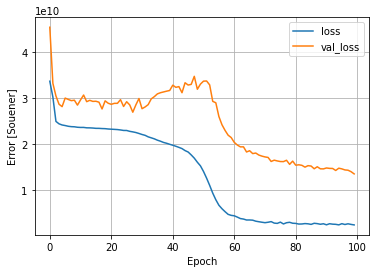

In [35]:
plot_loss(history)

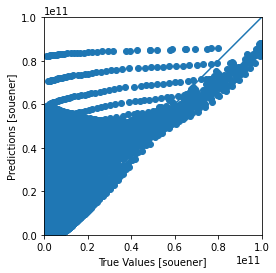

In [36]:
Y_pred = model.predict(X_test)

a = plt.axes(aspect='equal')
plt.scatter(Y_test.flatten(), Y_pred.flatten())
plt.xlabel('True Values [souener]')
plt.ylabel('Predictions [souener]')
lims = [0, 1e11]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [37]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  91047084633717.84
Mean Absolute Error:  7081518599.495827
Mean Percentage Error:  130.81143172668197
Total Squared Error:  2.325812081406219e+24
Mean Squared Error:  1.8089850520387486e+20
Number of Points:  12857


In [38]:
errorLst['Zmix+PCA(2 Components) DNN'] = err

/Users/dwyerdeighan/opt/miniconda3/envs/rom/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

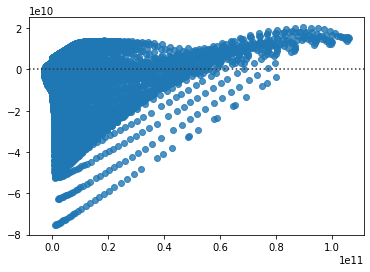

In [39]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Scrambled Data 

In [41]:
X = df[["Zmix","Cpv"]].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_shuffled, Y_shuffled = shuffle(X, Y, random_state=0)
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]



### Matern GP 

In [42]:
print ('Zmix+PCA(2 components) trained using 50% Test Flames \n')
gp,err, Y_pred = fitGPAndCalcL1Err(X_train, Y_train.flatten(), X_test, Y_test.flatten())

Zmix+PCA(2 components) trained using 50% Test Flames 



KeyboardInterrupt: 

In [ ]:
errorLst['Zmix+PCA(2 Components) GP 50% Random'] = err

In [ ]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Simple DNNN

In [ ]:
%%time
X_normalizer = preprocessing.Normalization()
X_normalizer.adapt(np.array(X_train.copy()))
model = build_and_compile_model(X_normalizer)
model.summary()
history = model.fit(X_train, Y_train,validation_split=0.2,verbose=0, epochs=100, callbacks=[es])

In [ ]:
plot_loss(history)

In [ ]:
Y_pred = model.predict(X_test)

a = plt.axes(aspect='equal')
plt.scatter(Y_test.flatten(), Y_pred.flatten())
plt.xlabel('True Values [souener]')
plt.ylabel('Predictions [souener]')
lims = [0, 1e11]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [24]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  24440832414393.043
Mean Absolute Error:  2973699040.5636992
Mean Percentage Error:  5.26128952564595
Total Squared Error:  4.248442610890747e+23
Mean Squared Error:  5.169050506011373e+19
Number of Points:  8219


In [27]:
errorLst['Zmix+PCA(2 Components) DNN 50% Random'] = err

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

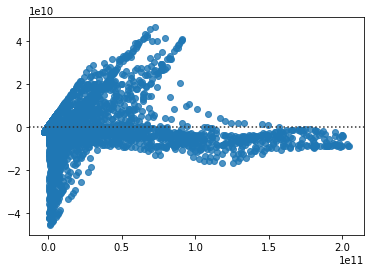

In [28]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

# Experiment II
## Training on all Untrimed Flames
### Zmix, 4 PCA

In [44]:
#ZmixPCA_frameworkincludedtrainexcludedtest
#ZmixPCA_frameworkincludedexcludedequalsplit
X_train,Y_train,X_test, Y_test  = getTrainTestData("ZmixPCA_frameworkincludedtrainexcludedtest")

### Matern GP

In [30]:
print ('Zmix+PCA(4 components) trained using Framework Included Flames and Test on Flames Excluded by Framework\n')
gp,err, Y_pred = fitGPAndCalcL1Err(X_train, Y_train.flatten(), X_test, Y_test.flatten())

Zmix+PCA(4 components) trained using Framework Included Flames and Test on Flames Excluded by Framework



C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\ipykernel_launcher.py:10: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  # Remove the CWD from sys.path while we load stuff.


GP Time for Initial Fit:  218.09375
GP Time for Prediction:  1.765625
Total Absolute Error:  34070245412856.35
Mean Absolute Error:  2649937420.3046083
Mean Percentage Error:  4.459035375224145
Total Squared Error:  3.789950971472544e+23
Mean Squared Error:  2.9477723975052845e+19
Number of Points:  12857


In [31]:
errorLst['Zmix+PCA(4 Components) GP'] = err

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

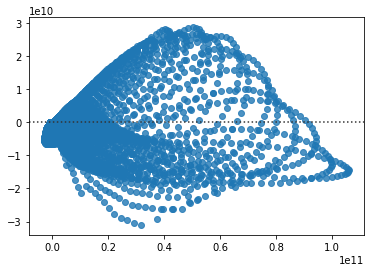

In [32]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Simple DNN 

In [45]:
X_normalizer = preprocessing.Normalization()
X_normalizer.adapt(np.array(X_train.copy()))
model = build_and_compile_model(X_normalizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_14 (Dense)             (None, 512)               3072      
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_19 (Dense)             (None, 512)              

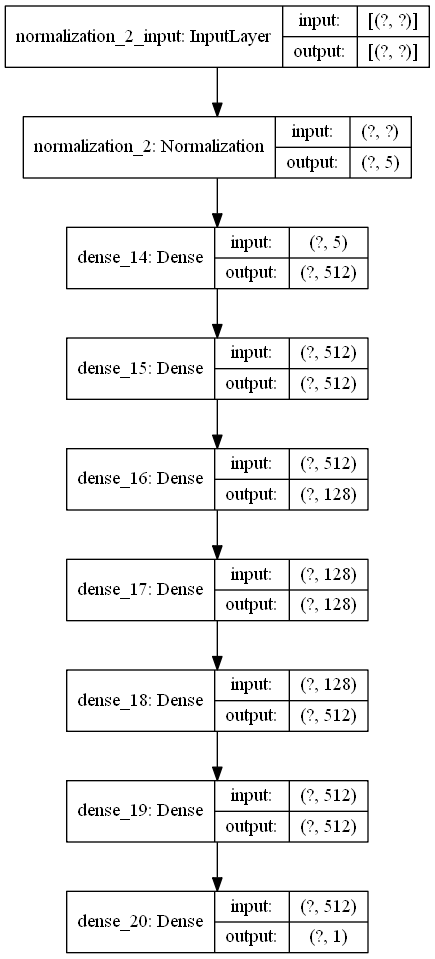

In [46]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)


In [47]:
%%time
history = model.fit(X_train, Y_train,validation_split=0.2,verbose=0, epochs=100, callbacks=[es])

Wall time: 59.4 s


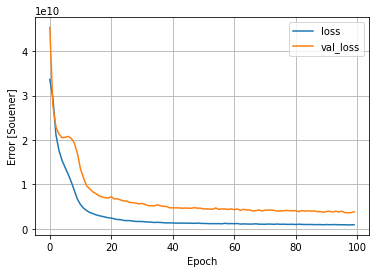

In [48]:
plot_loss(history)

In [49]:
Y_pred = model.predict(X_test)
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  34696176734201.55
Mean Absolute Error:  2698621508.454659
Mean Percentage Error:  2.365783531302725
Total Squared Error:  5.4109150520973305e+23
Mean Squared Error:  4.20853624647844e+19
Number of Points:  12857


In [37]:
errorLst['Zmix+PCA(4 Components) DNN'] = err

NameError: name 'errorLst' is not defined

<AxesSubplot:>

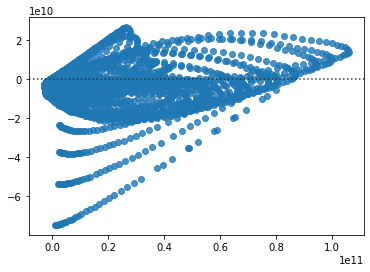

In [50]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Scrambled Data 

### Matern GP 

In [51]:
X = df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_shuffled, Y_shuffled = shuffle(X, Y, random_state=0)
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]



In [41]:
print ('Zmix+PCA(4 components) trained using 50% data\n')
gp,err, Y_pred = fitGPAndCalcL1Err(X_train, Y_train.flatten(), X_test, Y_test.flatten())

Zmix+PCA(4 components) trained using 50% data

GP Time for Initial Fit:  5320.625
GP Time for Prediction:  2.375
Total Absolute Error:  3973061426515.995
Mean Absolute Error:  483399613.88441354
Mean Percentage Error:  0.49245306615795975
Total Squared Error:  6.479068521889638e+22
Mean Squared Error:  7.883037500778243e+18
Number of Points:  8219


In [42]:
errorLst['Zmix+PCA(4 Components) GP 50% data'] = err

C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

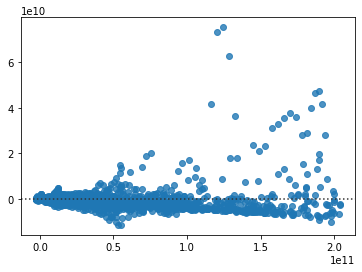

In [43]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Simple DNN 

In [52]:
X_normalizer = preprocessing.Normalization()
X_normalizer.adapt(np.array(X_train.copy()))
model = build_and_compile_model(X_normalizer)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_21 (Dense)             (None, 512)               3072      
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_26 (Dense)             (None, 512)              

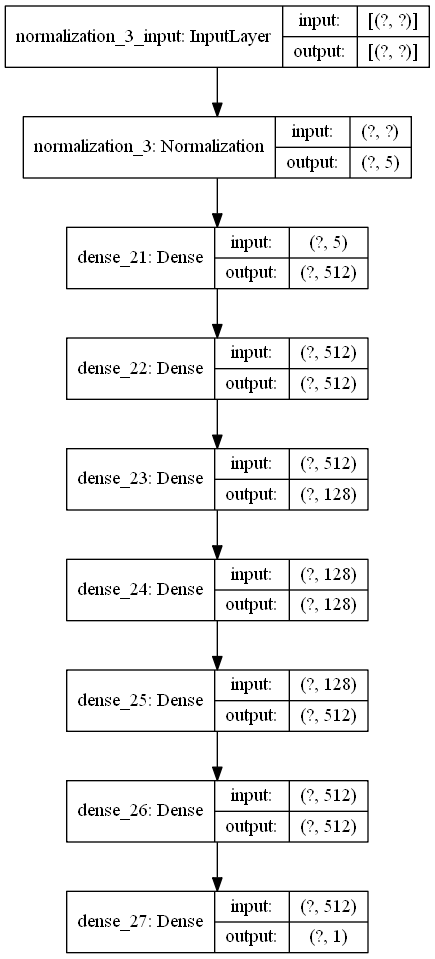

In [53]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [54]:
%%time
history = model.fit(X_train, Y_train,validation_split=0.2,verbose=0, epochs=100, callbacks=[es])

Wall time: 2min 40s


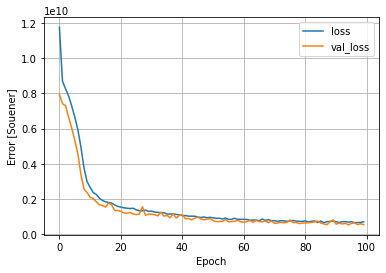

In [55]:
plot_loss(history)

In [56]:
Y_pred = model.predict(X_test)
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  5074892931279.571
Mean Absolute Error:  617458684.9105209
Mean Percentage Error:  4.007261541735772
Total Squared Error:  4.875432858102316e+22
Mean Squared Error:  5.931905168636471e+18
Number of Points:  8219


In [49]:
errorLst['Zmix+PCA(4 Components) DNN'] = err

<AxesSubplot:>

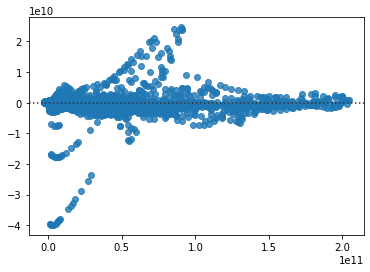

In [57]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

## Experiement III

### All Species Physics Constrained - DNN

In [16]:
X_allSpecies = df[icovariates].values
X= df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_allSpecies_shuffled,X_shuffled, Y_shuffled = shuffle(X_allSpecies,X,Y, random_state=0)


X_allSpecies_train = X_allSpecies_shuffled[::2]
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]

X_allSpecies_test = X_allSpecies_shuffled[1::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]

In [17]:
Y_test

array([5.58632012e+09, 4.02360148e+09, 5.81072585e+08, ...,
       7.87871399e+10, 3.31228134e+08, 1.02734466e+10])

In [18]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# create scaler
scaler_species = MinMaxScaler()
# fit and transform in one step
normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

# create scaler
scaler_zmixpca = MinMaxScaler()
# fit and transform in one step
normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)



scaler_souener = MinMaxScaler()
# fit and transform in one step

Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

normalized_souener_train = scaler_souener.fit_transform(Y_train)
normalized_souener_test = scaler_souener.fit_transform(Y_test)

In [19]:
normalized_souener_train = normalized_souener_train.flatten()
normalized_souener_test = normalized_souener_test.flatten()

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

In [20]:
normalized_souener_train.shape

(8220,)

In [21]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
species_inputs = keras.Input(shape=(53,), name="species_input")

linear_reduced_dims = layers.Dense(5, name="linear_layer")(species_inputs)

x = layers.Dense(32, activation="relu")(linear_reduced_dims)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

physics_pred = layers.Dense(5, name="physics")(linear_reduced_dims)

model = keras.Model(
    inputs=[species_inputs],
    outputs=[souener_pred, physics_pred],
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_layer (Dense)            (None, 5)            270         species_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         linear_layer[0][0]               
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           2112        dense[0][0]                      
_______________________________________________________________________________________

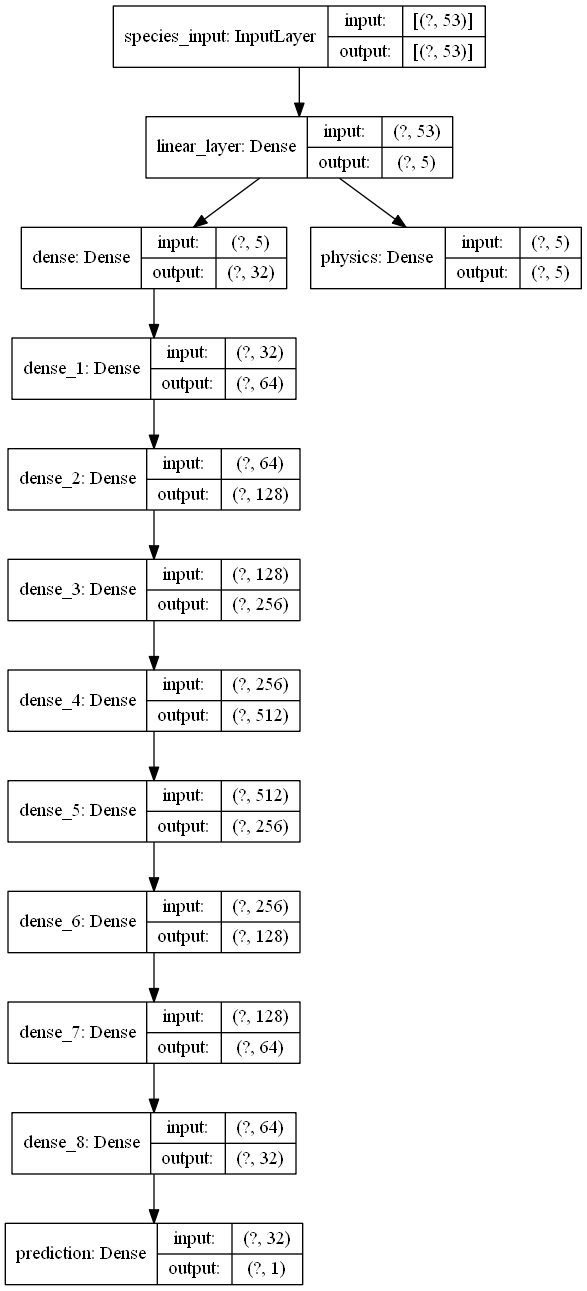

In [22]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [23]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer=opt,
    loss={
        "physics": keras.losses.MeanAbsoluteError(),
        "prediction": keras.losses.MeanAbsoluteError(),
    },
    loss_weights=[2.0, 0.2],
)



In [24]:
%%time
#batch_size=100,
history = model.fit(normalized_species_train, 
                    {
                        "physics": normalized_zmixpca_train,
                        "prediction":normalized_souener_train#Y_train
                    },
                    validation_split=0.2,
                    verbose=0, 
                    epochs=100
                   )

Wall time: 55.8 s


In [25]:
def plot_loss_physics_and_regression(history):
    '''
    fig, axs = plt.subplots(1, 2, figsize=(6,6))
    plt.subplots_adjust(wspace=.75)
    axs[0].plot(history.history['prediction_loss'], label='loss')
    axs[0].plot(history.history['val_prediction_loss'], label='val_loss')
    axs[0].set_title('Souener Prediction Loss')
    axs[0].set(xlabel='Epoch', ylabel='Souener Error')
    axs[0].legend()
    
    axs[1].plot(history.history['physics_loss'], label='loss')
    axs[1].plot(history.history['val_physics_loss'], label='val_loss')
    axs[1].set_title('Physics Loss')
    axs[1].set(xlabel='Epoch', ylabel='Physics Error')
    axs[1].legend()
    '''
    
    
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    ax.plot(history.history['prediction_loss'], label='loss')
    ax.plot(history.history['val_prediction_loss'], label='val_loss')
    ax.set_title('Souener Prediction Loss')
    ax.set(xlabel='Epoch', ylabel='Souener Error')
    ax.legend()

    ax2.plot(history.history['physics_loss'], label='loss')
    ax2.plot(history.history['val_physics_loss'], label='val_loss')
    ax2.set_title('Physics Loss')
    ax2.set(xlabel='Epoch', ylabel='Physics Error')
    ax2.legend()
        

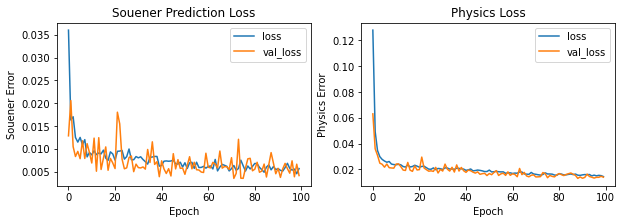

In [26]:
plot_loss_physics_and_regression(history)

In [27]:
predictions = model.predict(normalized_species_test)

normalized_souener_pred = predictions[0]

normalized_zmixpca_pred = predictions[1]

In [28]:
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [29]:
Y_pred = Y_pred.flatten()

In [30]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  7038652202119.852
Mean Absolute Error:  856387906.3292191
Mean Percentage Error:  184.38656287124007
Total Squared Error:  2.8491479336112997e+22
Mean Squared Error:  3.4665384275596785e+18
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

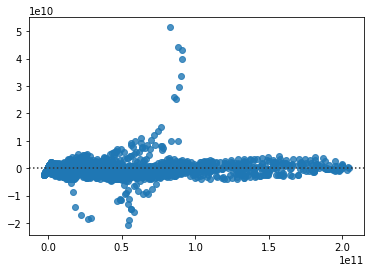

In [31]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

In [95]:
#Model Saved for the following configuration
'''
Total Absolute Error:  4075696778120.0723
Mean Absolute Error:  495887185.56029594
model.save("pcdnn_paper_1")
'''

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pcdnn_paper_1\assets


### All Species Unconstrained DNN

In [16]:
species_inputs = keras.Input(shape=(53,), name="species_input")

x = layers.Dense(5, activation="relu")(species_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

nlfullmodel = keras.Model(
    inputs=[species_inputs],
    outputs=[souener_pred],
)

nlfullmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 270       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

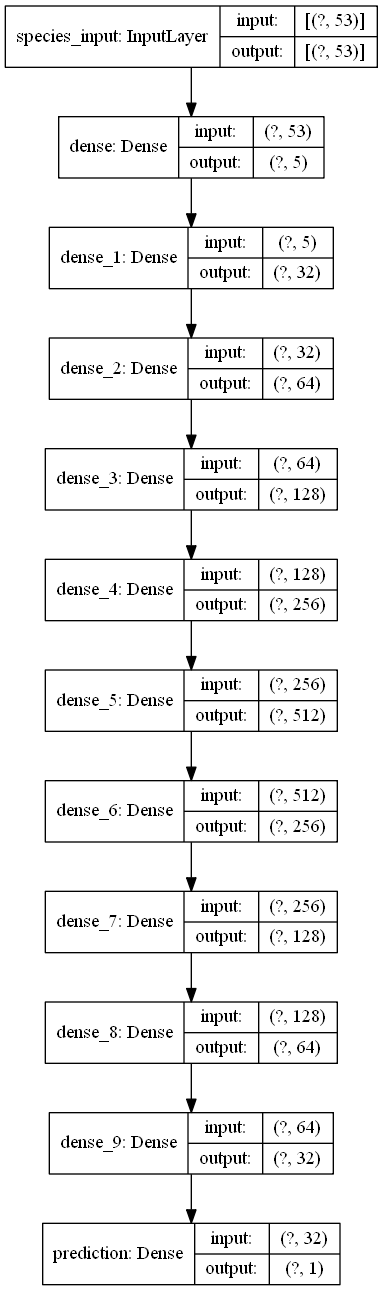

In [17]:
tf.keras.utils.plot_model(nlfullmodel,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [18]:
nlfullmodel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [20]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

X_allSpecies = df[icovariates].values
X= df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_allSpecies_shuffled,X_shuffled, Y_shuffled = shuffle(X_allSpecies,X,Y, random_state=0)


X_allSpecies_train = X_allSpecies_shuffled[::2]
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]

X_allSpecies_test = X_allSpecies_shuffled[1::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]

# create scaler
scaler_species = MinMaxScaler()
# fit and transform in one step
normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

# create scaler
scaler_zmixpca = MinMaxScaler()
# fit and transform in one step
normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)



scaler_souener = MinMaxScaler()
# fit and transform in one step

Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

normalized_souener_train = scaler_souener.fit_transform(Y_train)
normalized_souener_test = scaler_souener.fit_transform(Y_test)

In [21]:
normalized_souener_train = normalized_souener_train.flatten()
normalized_souener_test = normalized_souener_test.flatten()

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

In [22]:
nlfullmodel

In [23]:
%%time
history = nlfullmodel.fit(normalized_species_train, 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=100, 
                          callbacks=[es])

Wall time: 53.4 s


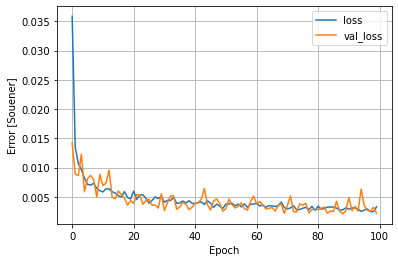

In [24]:
plot_loss(history)

In [27]:
predictions = nlfullmodel.predict(normalized_species_test)

normalized_souener_pred = predictions


In [28]:
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [29]:
Y_pred = Y_pred.flatten()

In [30]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  4145092665835.4023
Mean Absolute Error:  504330534.83822876
Mean Percentage Error:  130.5552204093304
Total Squared Error:  3.7183695940113127e+22
Mean Squared Error:  4.5241143618582707e+18
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

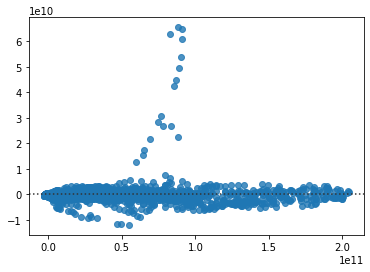

In [31]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))